In [1]:
import yahoo_fin.stock_info as si
import pandas as pd

In [2]:
start_date = "01/01/2001"
end_date = "30/12/2023"
window = 60

df = si.get_data("aapl", start_date=start_date, end_date=end_date)[["close"]]
train = pd.concat([df] + [df.shift(i) for i in range(1, window+1)], axis=1)[window:]
train.columns = ["target"] + ["lag_{}".format(i) for i in range(1, window+1)]
train = train.iloc[:, ::-1]
train.target = (train.target > train.lag_1).astype(int)
train

,lag_60,lag_59,lag_58,lag_57,lag_56,lag_55,lag_54,lag_53,lag_52,lag_51,...,lag_9,lag_8,lag_7,lag_6,lag_5,lag_4,lag_3,lag_2,lag_1,target
2001-03-29,0.265625,0.292411,0.304688,0.292411,0.295759,0.306920,0.295759,0.321429,0.306920,0.305804,...,0.350446,0.367188,0.351563,0.359375,0.386161,0.410714,0.388929,0.408393,0.395893,1
2001-03-30,0.292411,0.304688,0.292411,0.295759,0.306920,0.295759,0.321429,0.306920,0.305804,0.300223,...,0.367188,0.351563,0.359375,0.386161,0.410714,0.388929,0.408393,0.395893,0.402321,0
2001-04-02,0.304688,0.292411,0.295759,0.306920,0.295759,0.321429,0.306920,0.305804,0.300223,0.333705,...,0.351563,0.359375,0.386161,0.410714,0.388929,0.408393,0.395893,0.402321,0.394107,0
2001-04-03,0.292411,0.295759,0.306920,0.295759,0.321429,0.306920,0.305804,0.300223,0.333705,0.348214,...,0.359375,0.386161,0.410714,0.388929,0.408393,0.395893,0.402321,0.394107,0.385536,0
2001-04-04,0.295759,0.306920,0.295759,0.321429,0.306920,0.305804,0.300223,0.333705,0.348214,0.343750,...,0.386161,0.410714,0.388929,0.408393,0.395893,0.402321,0.394107,0.385536,0.361429,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,170.690002,171.210007,173.750000,172.399994,173.660004,174.910004,177.490005,178.990005,178.389999,179.800003,...,193.179993,194.710007,197.960007,198.110001,197.570007,195.889999,196.940002,194.830002,194.679993,0
2023-12-26,171.210007,173.750000,172.399994,173.660004,174.910004,177.490005,178.990005,178.389999,179.800003,180.710007,...,194.710007,197.960007,198.110001,197.570007,195.889999,196.940002,194.830002,194.679993,193.600006,0
2023-12-27,173.750000,172.399994,173.660004,174.910004,177.490005,178.990005,178.389999,179.800003,180.710007,178.850006,...,197.960007,198.110001,197.570007,195.889999,196.940002,194.830002,194.679993,193.600006,193.050003,1
2023-12-28,172.399994,173.660004,174.910004,177.490005,178.990005,178.389999,179.800003,180.710007,178.850006,178.720001,...,198.110001,197.570007,195.889999,196.940002,194.830002,194.679993,193.600006,193.050003,193.149994,1


In [3]:
from sklearn.preprocessing import MinMaxScaler


def get_X_y(train):
    y = train["target"]
    X = train.drop(["target"], axis=1)
    return X, y

def split_data(train, test_size=0.2):
    n = int(len(train) * (1 - test_size))
    X_train, y_train = get_X_y(train[:n])
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    
    X_test, y_test = get_X_y(train[n:])
    X_test = scaler.transform(X_test)
    
    return (X_train, y_train, X_test, y_test), scaler

(X_train, y_train, X_test, y_test), scaler = split_data(train)

In [4]:
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader
import torch

batch_size = 32

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32).unsqueeze(2), torch.tensor(y_train, dtype=torch.float32).flatten())
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32).unsqueeze(2), torch.tensor(y_test, dtype=torch.float32).flatten())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)    # why shuffle = True? (to avoid overfitting)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

C:\Users\jiumi\AppData\Local\Temp\ipykernel_8128\3496053527.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32).unsqueeze(2), torch.tensor(y_train, dtype=torch.float32).flatten())
C:\Users\jiumi\AppData\Local\Temp\ipykernel_8128\3496053527.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32).unsqueeze(2), torch.tensor(y_test, dtype=torch.float32).flatten())


In [5]:
assert train_dataset.tensors[0].shape[1] == window

In [35]:
import torch.nn as nn

hidden_dim = 32
output_dim = 1
num_layers = 2

lr = 1e-4


class StockLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(StockLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.classifier(out[:, -1, :])
        return out


model = StockLSTM(input_dim=1, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = nn.BCELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, patience=5, verbose=True)

In [36]:
len(train_loader)

144

In [37]:
def validate(test_loader):
    val_losses = []
    model.eval()
    with torch.no_grad():
        for X_batch_t, y_batch_t in test_loader:
            y_test_pred = model(X_batch_t).squeeze()
            val_loss = loss_fn(y_test_pred, y_batch_t)
            val_losses.append(val_loss.item())
    model.train()
    return np.mean(val_losses)

In [38]:
from tqdm import tqdm
import numpy as np

num_epochs = 50

history = np.zeros((num_epochs, len(train_loader)))

val_losses = []

torch.manual_seed(42)

for t in range(num_epochs):
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (X_batch, y_batch) in pbar:
        y_pred = model(X_batch).squeeze()
        loss = loss_fn(y_pred, y_batch)
        
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
        if i % 10 == 0 and i != 0:
            pbar.set_description(f"Epoch {t}, MSE: {loss.item():.4f}")
        history[t, i] = loss.item()
        
    val_loss_epoch = validate(test_loader)
    pbar.set_postfix(val_loss=val_loss_epoch)
    val_losses.append(val_loss_epoch)
    lr_scheduler.step(val_loss_epoch)

Epoch 6, MSE: 0.6807: 100%|██████████| 144/144 [00:00<00:00, 172.16it/s]


Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.


Epoch 12, MSE: 0.6860: 100%|██████████| 144/144 [00:00<00:00, 178.69it/s]


Epoch 00013: reducing learning rate of group 0 to 1.0000e-06.


Epoch 18, MSE: 0.6995: 100%|██████████| 144/144 [00:00<00:00, 158.65it/s]


Epoch 00019: reducing learning rate of group 0 to 1.0000e-07.


Epoch 24, MSE: 0.7022: 100%|██████████| 144/144 [00:00<00:00, 155.70it/s]


Epoch 00025: reducing learning rate of group 0 to 1.0000e-08.


Epoch 49, MSE: 0.6860: 100%|██████████| 144/144 [00:00<00:00, 144.79it/s]


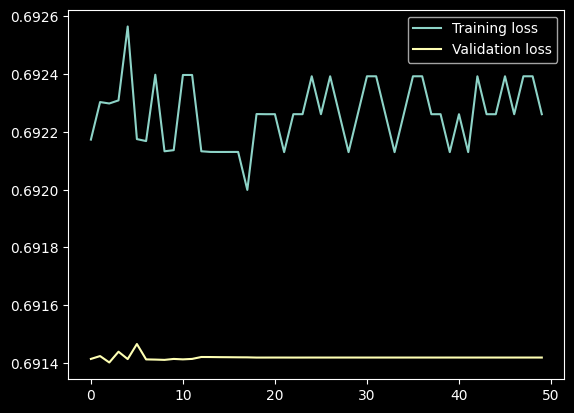

In [39]:
import matplotlib.pyplot as plt

plt.plot(history.mean(axis=1), label="Training loss")
plt.plot(val_losses, label="Validation loss")

plt.legend()
plt.show()

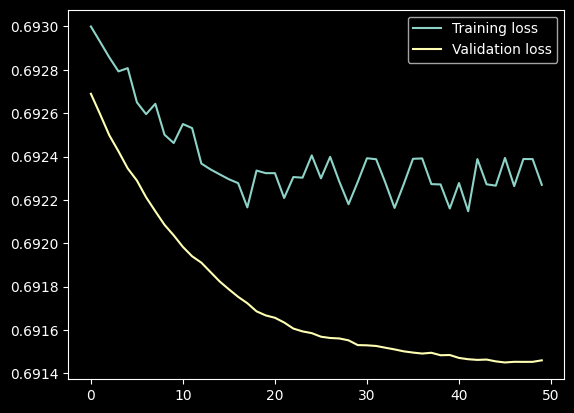

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.mean(axis=1), label="Training loss")
plt.plot(val_losses, label="Validation loss")

plt.legend()
plt.show()

In [24]:
with torch.no_grad():
    for X_batch_t, y_batch_t in test_loader:
        y_test_pred = model(X_batch_t).squeeze()
        val_loss = loss_fn(y_test_pred, y_batch_t)
        val_losses.append(val_loss.item())
        
y_test_pred

tensor([0.5193, 0.5193, 0.5193, 0.5193, 0.5193, 0.5193, 0.5193, 0.5193, 0.5193,
        0.5193, 0.5193, 0.5193, 0.5193, 0.5193, 0.5193, 0.5192, 0.5192, 0.5192,
        0.5192, 0.5192, 0.5192, 0.5192, 0.5193, 0.5193, 0.5193])

In [ ]:
print(f"Test MSE: {np.mean(val_losses):.4f}")


Test MSE: 6712.8433
